# Dive into Deep Learning: Classifying images

The goal of this blog post is to explain the process of training a deep learning model to classify images (pixels) of insects: beetles, cockroaches, and dragonflies. The neural network (model) will be evaluated on how it classfied the images using Shapley Additive Explanations.

The first step is to import all of the necessary libraries. This neural network will be using the tensorflow package and specifically, the keras module.

In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#import tensorflow as tf
#from tensorflow import keras
#import shap

#from PIL import Image
#import urllib
import io 

import random
import os

from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

Using TensorFlow backend.


The next step is to specify the image size because all the images need to be of the same size in the model and specify three color channels.

In [2]:
# image specifications
width=200
height=200
size=(width,height)
channels = 3

Now, we will create the training data by finding the file paths of each image. The file paths of the images will be added to a training file list and the corresponding image classifiation (type of insect) will be added to a categories list. These lists are appended to a training dataframe.

In [3]:
# training data
trainfiles = []
categories = []

for path in os.listdir("insects/train/beetles"):
    full_path = os.path.join("insects/train/beetles", path)
    if os.path.isfile(full_path):
        trainfiles.append(full_path)
        categories.append("beetles")
        
for path in os.listdir("insects/train/cockroach"):
    full_path = os.path.join("insects/train/cockroach", path)
    if os.path.isfile(full_path):
        trainfiles.append(full_path)
        categories.append("cockroach")

for path in os.listdir("insects/train/dragonflies"):
    full_path = os.path.join("insects/train/dragonflies", path)
    if os.path.isfile(full_path):
        trainfiles.append(full_path)
        categories.append("dragonflies")

df_train = pd.DataFrame({
    'filename': trainfiles,
    'category': categories
})        

Similarly, we will create the testing data. The file paths of the images will be added to a test file list and the corresponding image classifiation (type of insect) will be added to a categories list. These lists are appended to a test dataframe. 

In [4]:
# test data
testfiles = []
categories = []

for path in os.listdir("insects/test/beetles"):
    full_path = os.path.join("insects/test/beetles", path)
    if os.path.isfile(full_path):
        testfiles.append(full_path)
        categories.append("beetles")
        
for path in os.listdir("insects/test/cockroach"):
    full_path = os.path.join("insects/test/cockroach", path)
    if os.path.isfile(full_path):
        testfiles.append(full_path)
        categories.append("cockroach")

for path in os.listdir("insects/test/dragonflies"):
    full_path = os.path.join("insects/test/dragonflies", path)
    if os.path.isfile(full_path):
        testfiles.append(full_path)
        categories.append("dragonflies")
        
df_test = pd.DataFrame({
    'filename': testfiles,
    'category': categories
})        

This neural network will use a convolution 2D neural net architecture. We will add layers sequentially and each one has separate biases and weights. The output and shape of each layer is shown below. The loss function is 'categorical_crossentropy' and while training the model, this function will be minimized.

In [5]:
# neural net model
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(width,height,channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0

The training data will be split into training and validation sets to be used in the model.

In [7]:
train_df,validate_df = train_test_split(df_train,test_size=0.2,
  random_state=42)

total_train=train_df.shape[0]
total_validate=df_test.shape[0]
batch_size = 10

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

After some research, ImageDataGenerator seemed like the most optimal solution to create this image classification model as it can efficiently load images in batches. The output shows the number of images in each data set. 

In [8]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col='filename',y_col='category',
                                                 target_size=size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)


validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    x_col='filename',
    y_col='category',
    target_size=size,
    class_mode='categorical',
    batch_size=batch_size)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_generator = test_datagen.flow_from_dataframe(df_test,x_col='filename',y_col='category',
                                                 target_size=size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

Found 815 validated image filenames belonging to 3 classes.
Found 204 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.


Now, we will fit the model on the training data and validate it on the validation data. Various epochs and batch sizes were tried and due to the time it took to run the model, 3 and 10 were chosen respectively. 

In [9]:
hist = model.fit(
    train_generator, 
    epochs=3,
    validation_data=validation_generator,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/3
82/82 [==============================] - 52s 638ms/step - loss: 1.2775 - accuracy: 0.6712 - val_loss: 5.3428 - val_accuracy: 0.3088
Epoch 2/3
82/82 [==============================] - 72s 877ms/step - loss: 0.8408 - accuracy: 0.7190 - val_loss: 1.2377 - val_accuracy: 0.3578
Epoch 3/3
82/82 [==============================] - 56s 683ms/step - loss: 0.7113 - accuracy: 0.7411 - val_loss: 0.6713 - val_accuracy: 0.7451


As the plot illustrates, the model does not have a high accuracy. A lot of layers were added to the model including batch normalization and dropout layers to make the code run more efficiently. 

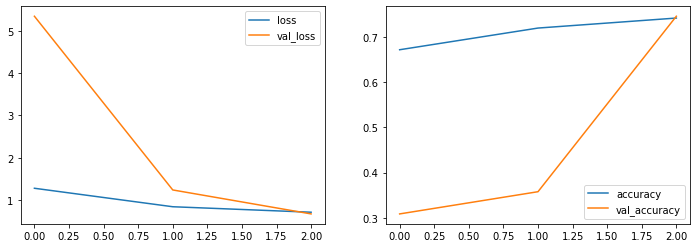

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(hist.history[measure], label=measure)
    ax.plot(hist.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass

In [11]:
model.save("model1.h5")

The test accuracy is about 63%. 

In [12]:
test_loss, test_acc = model.evaluate(test_generator)
test_acc

18/18 [==============================] - 2s 126ms/step - loss: 1.0234 - accuracy: 0.6333


0.6333333253860474

The following code manipulates the test data frame to be used for predictions.

In [13]:
test_df = pd.DataFrame({
    'filename': testfiles
})
nb_samples = test_df.shape[0]

The following code makes predictions from the model.

In [14]:
model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

array([[0.01055039, 0.10431192, 0.88513774],
       [0.5179904 , 0.3979396 , 0.08407004],
       [0.00986549, 0.1391683 , 0.8509662 ],
       [0.00415045, 0.00791699, 0.9879325 ],
       [0.00904628, 0.10130297, 0.88965076],
       [0.05024753, 0.44853497, 0.50121754],
       [0.01530208, 0.26121807, 0.7234798 ],
       [0.08065066, 0.04041677, 0.8789326 ],
       [0.05820866, 0.19350283, 0.7482886 ],
       [0.00186364, 0.01259162, 0.98554474],
       [0.16424161, 0.3218607 , 0.5138977 ],
       [0.03824452, 0.19226295, 0.7694925 ],
       [0.51631653, 0.31063876, 0.17304465],
       [0.12166991, 0.7953933 , 0.08293679],
       [0.00248274, 0.0139092 , 0.98360807],
       [0.18625101, 0.582944  , 0.23080507],
       [0.00169783, 0.01214392, 0.98615825],
       [0.29984197, 0.51619685, 0.1839611 ],
       [0.01561059, 0.05201594, 0.93237346],
       [0.02889553, 0.7724411 , 0.1986634 ],
       [0.00245844, 0.01389793, 0.9836436 ],
       [0.31747028, 0.18811136, 0.49441832],
       [0.

Checking the prediction of one image by feeding an image of a beetle. The classification was a beetle. Yay!

In [51]:
results={
    0:'beetles',
    1:'cockroach',
    2:'dragonflies'
}
from PIL import Image
import numpy as np
im=Image.open("insects/test/beetles/5556745.jpg")
im=im.resize(size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

0 beetles


We will describe how well the model performed using shapley additive explanations.

In [16]:
import shap

I tried the following code and several other versions of what is below to convert the training and test sets into numpy arrays to be used in the gradient explainer and for the shapley values. After analyzing the output of the train and test generator (code above), I realized that the data was in batches and I would need to unbatch the data for this to work and plot the images correctly. So, I scratched this idea and skipped to what is shown below. 

In [90]:
# xtrain = []
# ytrain = []

# xtrain=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
# ytrain=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])

# xtest = []
# ytest = []

# xtest=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
# ytest=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])

# ytest = np.where(ytest == 0, "beetles", np.where(ytest == 1, "cockroach", "dragonflies"))

# explainer = shap.GradientExplainer(model, xtrain)
# shap_vals = explainer.shap_values(xtest[:3])

The following code produces the shapley values on the test data using a gradient from the model and background (training data). 

In [17]:
explainer = shap.GradientExplainer(model, train_generator[0][0])
shap_vals, index = explainer.shap_values(test_generator[0][0], ranked_outputs = 3)

Now, we will create a numpy array to label the images. 

In [42]:
names = ['beetles', 'cockroach', 'dragonflies']
index_names = np.vectorize(lambda x: names[x])(index)

Finally, we will plot the images and see what parts of the images are most important in creating the image classification. 

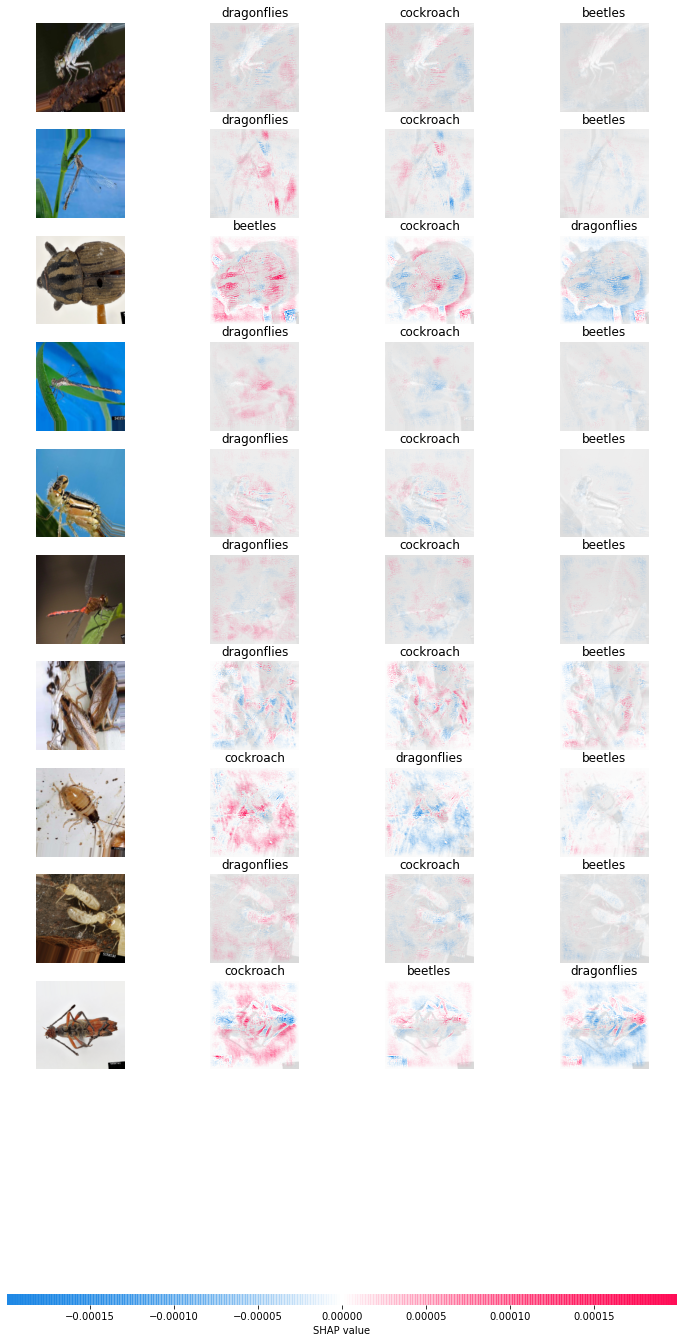

In [43]:
shap.image_plot(shap_vals, test_generator[0][0], labels = index_names, show = False)
plt.savefig('shap.jpg')